<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TPU/MNIST_with_TensorFlow_addons_Focal_Loss_and_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install tensorflow==2.1.0
!pip install  tensorflow-addons==0.9.1
#!pip install -q efficientnet --upgrade
#!pip install tensorflow-addons
#!pip install -q "tqdm>=4.36.1"

     |████████████████████████████████| 1.0MB 3.5MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [1]:
!pip install focal-loss


In [0]:
import tensorflow.keras.backend as K
def FocalLoss(target, input):
    
    gamma = 2.
    input = tf.cast(input, tf.float32)
    
    max_val = K.clip(-input, 0, 1)
    loss = input - input * target + max_val + K.log(K.exp(-max_val) + K.exp(-input - max_val))
    invprobs = tf.math.log_sigmoid(-input * (target * 2.0 - 1.0))
    loss = K.exp(invprobs * gamma) * loss
    
    return K.mean(K.sum(loss, axis=1))

In [2]:
#!pip install tf-nightly

     |████████████████████████████████| 519.0MB 29kB/s 
     |████████████████████████████████| 460kB 39.9MB/s 
     |████████████████████████████████| 3.0MB 36.9MB/s 


In [25]:
import tensorflow as tf
print(f"tf.__version__: {tf.__version__}")
tf.config.optimizer.set_jit(True)
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
import os

try: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    strategy = tf.distribute.get_strategy()
    raise BaseException('ERROR: Not connected to a TPU runtime.')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

print("REPLICAS: ", tpu_strategy.num_replicas_in_sync)

def get_dataset(batch_size=200):
  # datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True,
  #                            try_gcs=True)
  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
  y_train, y_test = tf.keras.utils.to_categorical(y_train,10), tf.keras.utils.to_categorical(y_test,10)

  def scale(image, label):
    image = tf.reshape(image,(28,28,1))
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).map(scale).cache().shuffle(10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).map(scale).cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

  return train_dataset, test_dataset

def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(32, 3, activation="elu", input_shape=(28, 28, 1)),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(128, "elu"),
       tf.keras.layers.Dense(10)])
  
train_dataset, test_dataset = get_dataset()

with tpu_strategy.scope():
  model = create_model()
  model.compile(optimizer=tfa.optimizers.Lookahead(tfa.optimizers.RectifiedAdam(
                          lr=1e-3,
                          total_steps=10000,
                          warmup_proportion=0.1,
                          min_lr=1e-5,
                      ),sync_period=6, slow_step_size=0.5),
                loss=KerasFocalLoss,
                metrics=tfa.metrics.f_scores.F1Score(num_classes=10,average="macro"))
  
model.fit(train_dataset,epochs=10,validation_data=test_dataset, callbacks=[tfa.callbacks.TQDMProgressBar()],verbose=0)

tf.__version__: 2.2.0-rc3
Running on TPU  ['10.107.165.154:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.107.165.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.107.165.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [0]:
import tensorflow as tf
print(f"tf.__version__: {tf.__version__}")
tf.config.optimizer.set_jit(True)
import tensorflow_addons as tfa;tfa.options.TF_ADDONS_PY_OPS = True
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
import os

strategy = tf.distribute.MirroredStrategy()
def get_dataset(batch_size=200):
  datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True,
                             try_gcs=True)
  mnist_train, mnist_test = datasets['train'], datasets['test']

  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0

    return image, label

  train_dataset = mnist_train.map(scale).cache().shuffle(10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  test_dataset = mnist_test.map(scale).cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

  return train_dataset, test_dataset

def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(32, 3, activation=tfa.activations.mish, input_shape=(28, 28, 1)),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(128, activation=tfa.activations.mish),
       tf.keras.layers.Dense(10)])
  
train_dataset, test_dataset = get_dataset()
with strategy.scope():
  model = create_model()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy',f1])
  
model.fit(train_dataset,epochs=10,validation_data=test_dataset, callbacks=[tfa.callbacks.TQDMProgressBar()],verbose=0)

tf.__version__: 2.2.0-dev20200418
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


In [0]:
!pip list tensorflow-addons

In [0]:
def get_dataset(batch_size=200):
  datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True,
                             try_gcs=True)
  mnist_train, mnist_test = datasets['train'], datasets['test']

  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0

    return image, label

  train_dataset = mnist_train.map(scale).shuffle(10000).batch(batch_size)
  test_dataset = mnist_test.map(scale).batch(batch_size)

  return train_dataset, test_dataset

In [0]:
def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(128, activation='relu'),
       tf.keras.layers.Dense(10)])

In [0]:
train_dataset, test_dataset = get_dataset()

In [0]:
with tpu_strategy.scope():
  model = create_model()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy'])

In [0]:
model.fit(train_dataset,epochs=10,validation_data=test_dataset,callbacks=[tfa.callbacks.TQDMProgressBar()])

Epoch 1/10


Epoch 1/10



TypeError: ignored

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib
Learning rate schedule: 0.003 to 0.005 to 0.000521


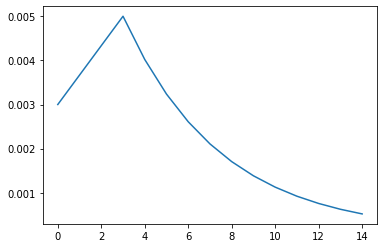

In [0]:
%pylab
%matplotlib inline
LR_START = 0.003
LR_MAX = 0.005 
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
EPOCHS=15
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
with tpu_strategy.scope():
  inputs = tf.keras.layers.Input(shape=(784,))
  x = tf.keras.layers.Dense(512, activation="relu")(inputs)
  outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
  model = tf.keras.models.Model(inputs, outputs)
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.fit(train_dataset)

Train for 938 steps
  0/938 [..............................] - ETA: 0s

NotFoundError: ignored

In [0]:
with tpu_strategy.scope():
  inputs = tf.keras.layers.Input(shape=(784,))
  x = tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, activation=tfa.activations.mish))(inputs)
  outputs = tfa.layers.WeightNormalization(tf.keras.layers.Dense(10, activation='softmax'))(x)
  model = tf.keras.models.Model(inputs, outputs)
  model.compile(optimizer = tfa.optimizers.Lookahead(tfa.optimizers.RectifiedAdam(lr=1e-3,total_steps=10000,warmup_proportion=0.1,min_lr=1e-5,), sync_period=6, slow_step_size=0.5),loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, callbacks=[tfa.callbacks.tqdm_progress_bar.TQDMProgressBar(), tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)],verbose=0)

Epoch 1/15



Epoch 00001: LearningRateScheduler reducing learning rate to 0.003.




RuntimeError: ignored